In [1]:
import geopandas as gpd
import pandas as pd

import mapillary as mly
#import json

import glob


import gzip

from datetime import datetime


import os
import json

In [2]:

## POINTS
# https://www.mapillary.com/developer/api-documentation/points?locale=de_DE

# --- 1) Markierungen-Definitionen  --------------------------------
cw_marking = "marking--discrete--symbol--bicycle"  # Fahrradmarkierung

# --- 2) Load Mapillary map feature points data from parquet files (RAM-sparsam) ---
# Idee: nicht alles in einem Rutsch lesen, sondern pro Datei früh filtern (value + Spalten)
parquet_files = sorted(glob.glob("../../output/mapillary_map-feature-points_*.parquet"))
print(f"Found parquet files: {len(parquet_files)}")

# Nur Spalten behalten, die in diesem Notebook später wirklich genutzt werden
needed_columns = ["id", "value", "first_seen_at", "last_seen_at", "geometry"]

filtered_parts = []
seen_ids = set()
target_value = cw_marking

for i, file_path in enumerate(parquet_files, start=1):
    # GeoParquet: geopandas kann (meist) selektiv Spalten lesen
    try:
        gdf_part = gpd.read_parquet(file_path, columns=needed_columns)
    except TypeError:
        # ältere geopandas/pyarrow combos unterstützen columns= evtl. nicht
        gdf_part = gpd.read_parquet(file_path)
        # Spaltenauswahl danach (spart weniger RAM, ist aber robust)
        missing = [c for c in needed_columns if c not in gdf_part.columns]
        if missing:
            raise KeyError(f"Missing columns {missing} in {file_path}")
        gdf_part = gdf_part[needed_columns]

    # Früh filtern: nur bicycle marking
    gdf_part = gdf_part[gdf_part["value"] == target_value]
    if gdf_part.empty:
        continue

    # Früh zeitlich filtern (reduziert Datenmenge für spätere Schritte)
    # String-Vergleich funktioniert bei ISO-Datum; wir casten trotzdem robust zu datetime
    gdf_part["last_seen_at"] = pd.to_datetime(gdf_part["last_seen_at"], errors="coerce")
    gdf_part["first_seen_at"] = pd.to_datetime(gdf_part["first_seen_at"], errors="coerce")
    gdf_part = gdf_part[(gdf_part["last_seen_at"] > pd.Timestamp("2023-01-01")) & (gdf_part["first_seen_at"] > pd.Timestamp("2000-01-01"))]
    if gdf_part.empty:
        continue

    # Inkrementell deduplizieren über alle Dateien
    # (spart RAM, weil wir Duplikate gar nicht erst in filtered_parts sammeln)
    gdf_part = gdf_part.drop_duplicates(subset=["id"])
    new_mask = ~gdf_part["id"].isin(seen_ids)
    if not new_mask.any():
        continue
    new_ids = gdf_part.loc[new_mask, "id"].tolist()
    seen_ids.update(new_ids)
    gdf_part = gdf_part.loc[new_mask].copy()

    filtered_parts.append(gdf_part)
    if i % 5 == 0:
        print(f"  processed {i}/{len(parquet_files)} files, kept rows so far: {sum(len(x) for x in filtered_parts)}")

if filtered_parts:
    # CRS aus erstem Part übernehmen
    mapillary_mf_points_cw = gpd.GeoDataFrame(pd.concat(filtered_parts, ignore_index=True), crs=filtered_parts[0].crs)
else:
    mapillary_mf_points_cw = gpd.GeoDataFrame(columns=needed_columns, geometry="geometry", crs="EPSG:4326")

# --- 2b) Read dataset metadata (instead of parsing dates from filenames) ---
metadata_path = os.path.join("..", "..", "output", "ml-mf_metadata.json")
ml_mf_metadata = None
ml_data_from = None
processed_date = None
bundeslaender_meta = {}

if os.path.exists(metadata_path):
    with open(metadata_path, "r", encoding="utf-8") as f:
        ml_mf_metadata = json.load(f)
    ml_data_from = ml_mf_metadata.get("ml_data_from")
    processed_date = ml_mf_metadata.get("processed_date")
    bundeslaender_meta = ml_mf_metadata.get("bundeslaender", {})
    print("✅ Loaded metadata:", metadata_path)
    print("  ml_data_from:", ml_data_from)
    print("  processed_date:", processed_date)
    print("  bundeslaender:", len(bundeslaender_meta))
else:
    print("⚠️ Metadata not found:", metadata_path)

# Keep a `dates` variable for backwards compatibility with later cells
dates = [d for d in [ml_data_from, processed_date] if d]

mapillary_mf_points_cw

Found parquet files: 16


  processed 5/16 files, kept rows so far: 41694


  processed 10/16 files, kept rows so far: 79019


  processed 15/16 files, kept rows so far: 91962


✅ Loaded metadata: ../../output/ml-mf_metadata.json
  ml_data_from: 2026-02-04T01:35:14.756761+00:00
  processed_date: 2026-02-04T07:14:07.957571+00:00
  bundeslaender: 16


,id,value,first_seen_at,last_seen_at,geometry
0,965648028573346,marking--discrete--symbol--bicycle,2024-05-09,2024-05-09,POINT (13.09177 52.41353)
1,965648061906676,marking--discrete--symbol--bicycle,2024-05-09,2024-05-09,POINT (13.09211 52.41353)
2,965648031906679,marking--discrete--symbol--bicycle,2024-05-09,2024-05-09,POINT (13.09288 52.41351)
3,965648035240012,marking--discrete--symbol--bicycle,2024-05-09,2024-05-09,POINT (13.09363 52.41347)
4,319726611164320,marking--discrete--symbol--bicycle,2024-05-09,2024-05-09,POINT (13.0948 52.4134)
...,...,...,...,...,...
92127,652404427207561,marking--discrete--symbol--bicycle,2025-08-02,2025-08-02,POINT (12.09208 50.88888)
92128,509138035470993,marking--discrete--symbol--bicycle,2024-11-30,2024-11-30,POINT (12.08914 50.88742)
92129,668591718378586,marking--discrete--symbol--bicycle,2023-01-16,2023-01-16,POINT (12.44325 50.99593)
92130,148846937652217,marking--discrete--symbol--bicycle,2023-01-16,2023-01-16,POINT (12.44366 50.99468)


In [3]:
# ✅ Loaded metadata: ../../output/ml-mf_metadata.json
#   ml_data_from: 2026-01-03T16:17:44.025499+00:00
#   processed_date: 2026-01-03T21:19:40.795942+00:00
#   bundeslaender: 16

## Verarbeitung fuer export fuer radinfra.de

In [4]:
# ### zeitlicher Filter: only signs seen after 2023-01-01

# # Bereits beim Einlesen gefiltert; hier nur noch ein Safety-Filter (falls Zelle 2 übersprungen/anders genutzt wurde)
# mapillary_mf_points_cw = mapillary_mf_points_cw.copy()
# mapillary_mf_points_cw["last_seen_at"] = pd.to_datetime(mapillary_mf_points_cw["last_seen_at"], errors="coerce")
# mapillary_mf_points_cw["first_seen_at"] = pd.to_datetime(mapillary_mf_points_cw["first_seen_at"], errors="coerce")

# mapillary_mf_points_cw = mapillary_mf_points_cw[mapillary_mf_points_cw["last_seen_at"] > pd.Timestamp("2023-01-01")].copy()
# mapillary_mf_points_cw = mapillary_mf_points_cw[mapillary_mf_points_cw["first_seen_at"] > pd.Timestamp("2000-01-01")].copy()

# len(mapillary_mf_points_cw)

In [5]:
### cehck if really inside germany
import gzip
import json

gz_path = "../utils/OSMB-germany.geojson.gz"

# Try GDAL's virtual filesystem (/vsigzip) via pyogrio engine first
try:
    germany_boundary = gpd.read_file(f"/vsigzip/{gz_path}", engine="pyogrio")
except Exception:
    # Fallback: manual gzip decompress + GeoJSON parse
    with gzip.open(gz_path, "rt", encoding="utf-8") as f:
        geojson_obj = json.load(f)
    germany_boundary = gpd.GeoDataFrame.from_features(geojson_obj, crs="EPSG:4326")

In [6]:
# Clip traffic signs to Germany boundary

mapillary_mf_points_cw = gpd.sjoin(
    mapillary_mf_points_cw, 
    germany_boundary[['geometry']], 
    predicate='within', 
    how='inner'
)
mapillary_mf_points_cw = mapillary_mf_points_cw.drop(columns=['index_right'])

print(f"Traffic signs after clipping to Germany: {len(mapillary_mf_points_cw)}")

Traffic signs after clipping to Germany: 90279


In [7]:
### räumlicher Filter (Alle Traffic sign an Autobahnen raus, wg vielen falsch-positiven dort)

In [8]:
# ## parse autobahnen
# set_date = "251115" 
# motorways=gpd.read_parquet(f"processed_osm_files/processed_motorways_germany_{set_date}.parquet")

# ## now create a buffer around the traffic signs to check if there is a cycleway nearby
# mapillary_trafficsigns_cw_buffered_30 = mapillary_trafficsigns_cw.to_crs(25833).copy()
# mapillary_trafficsigns_cw_buffered_30["geometry"] = mapillary_trafficsigns_cw_buffered_30.geometry.buffer(30)
# mapillary_trafficsigns_cw_buffered_30 = mapillary_trafficsigns_cw_buffered_30.to_crs(mapillary_trafficsigns_cw.crs)


In [9]:
# # helper 
# def mark_intersections(buffered_df, target_layer, column_name="has_intersection"):
#     """
#     Marks which geometries in `buffered_df` intersect with `target_layer`.

#     Parameters:
#     - buffered_df (GeoDataFrame): The GeoDataFrame containing buffered geometries.
#     - target_layer (GeoDataFrame): The GeoDataFrame to check for intersections (e.g., cycleways, motorways).
#     - column_name (str): Name of the column to add/overwrite in `buffered_df` indicating intersection (bool).

#     Returns:
#     - GeoDataFrame: `buffered_df` with a new boolean column `column_name`.
#     """
#     # Ensure CRS matches
#     buffered_df = buffered_df.to_crs(target_layer.crs)

#     # Perform spatial join to find intersecting geometries
#     joined = gpd.sjoin(buffered_df, target_layer, how="inner", predicate="intersects")

#     # Initialize the new column to False
#     buffered_df[column_name] = False

#     # Set True for geometries that intersect
#     matches = joined.index.unique()
#     buffered_df.loc[matches, column_name] = True

#     return buffered_df


In [10]:
# # For motorways (just 30m for both)
# mapillary_trafficsigns_cw_buffered_30_mw = mark_intersections(mapillary_trafficsigns_cw_buffered_30, motorways, column_name="has_mw_intersection")

# mapillary_trafficsigns_cw_30_mw_false=mapillary_trafficsigns_cw_buffered_30_mw[(mapillary_trafficsigns_cw_buffered_30_mw.has_mw_intersection== False)].copy()

# # keep only entries in mapillary_trafficsigns_cw that are present in mapillary_trafficsigns_cw_30_mw_false
# mapillary_trafficsigns_cw = mapillary_trafficsigns_cw[mapillary_trafficsigns_cw["id"].isin(mapillary_trafficsigns_cw_30_mw_false["id"])].copy()
# len(mapillary_trafficsigns_cw)

In [11]:
# ### calculate days between first_seen_at and last_seen_at (vektorisiert, RAM/CPU-sparsam)

mapillary_mf_points_cw = mapillary_mf_points_cw.copy()
mapillary_mf_points_cw["first_seen_at"] = pd.to_datetime(mapillary_mf_points_cw["first_seen_at"], errors="coerce")
mapillary_mf_points_cw["last_seen_at"] = pd.to_datetime(mapillary_mf_points_cw["last_seen_at"], errors="coerce")

mapillary_mf_points_cw["delta_days_seen"] = (mapillary_mf_points_cw["last_seen_at"] - mapillary_mf_points_cw["first_seen_at"]).dt.days

In [12]:
mapillary_mf_points_cw

,id,value,first_seen_at,last_seen_at,geometry,delta_days_seen
0,965648028573346,marking--discrete--symbol--bicycle,2024-05-09,2024-05-09,POINT (13.09177 52.41353),0
1,965648061906676,marking--discrete--symbol--bicycle,2024-05-09,2024-05-09,POINT (13.09211 52.41353),0
2,965648031906679,marking--discrete--symbol--bicycle,2024-05-09,2024-05-09,POINT (13.09288 52.41351),0
3,965648035240012,marking--discrete--symbol--bicycle,2024-05-09,2024-05-09,POINT (13.09363 52.41347),0
4,319726611164320,marking--discrete--symbol--bicycle,2024-05-09,2024-05-09,POINT (13.0948 52.4134),0
...,...,...,...,...,...,...
92127,652404427207561,marking--discrete--symbol--bicycle,2025-08-02,2025-08-02,POINT (12.09208 50.88888),0
92128,509138035470993,marking--discrete--symbol--bicycle,2024-11-30,2024-11-30,POINT (12.08914 50.88742),0
92129,668591718378586,marking--discrete--symbol--bicycle,2023-01-16,2023-01-16,POINT (12.44325 50.99593),0
92130,148846937652217,marking--discrete--symbol--bicycle,2023-01-16,2023-01-16,POINT (12.44366 50.99468),0


In [13]:
#mapillary_mf_points_cw[mapillary_mf_points_cw.delta_days_seen>180]

In [14]:

## mind 2 mal gesehn, mind 180 tage dazwischen
mapillary_mf_points_cw = mapillary_mf_points_cw[mapillary_mf_points_cw.delta_days_seen>180].copy()
mapillary_mf_points_cw

,id,value,first_seen_at,last_seen_at,geometry,delta_days_seen
11,638543051968867,marking--discrete--symbol--bicycle,2025-02-05,2025-08-08,POINT (13.09045 52.39049),184
13,638543148635524,marking--discrete--symbol--bicycle,2025-02-05,2025-08-08,POINT (13.09141 52.39196),184
17,988374642635257,marking--discrete--symbol--bicycle,2024-04-12,2025-03-26,POINT (13.0935 52.3892),348
32,7986094348143938,marking--discrete--symbol--bicycle,2024-07-12,2025-07-30,POINT (13.11625 52.55297),383
40,2046378772364369,marking--discrete--symbol--bicycle,2023-09-14,2025-03-26,POINT (13.11017 52.39158),559
...,...,...,...,...,...,...
92099,1329244044264721,marking--discrete--symbol--bicycle,2022-05-15,2024-03-27,POINT (11.59301 50.92856),682
92103,1716012415405301,marking--discrete--symbol--bicycle,2022-04-02,2024-10-17,POINT (11.61199 50.88618),929
92105,1716012412071968,marking--discrete--symbol--bicycle,2022-04-02,2024-10-17,POINT (11.61209 50.88621),929
92112,1016731365595454,marking--discrete--symbol--bicycle,2022-03-27,2024-10-17,POINT (11.61558 50.88714),935


In [15]:
# # Hinweise ergänzen

# mapillary_mf_points_cw["Hinweis"] = mapillary_mf_points_cw["delta_days_seen"].apply(
#     lambda x: "Nur einmalig detektiert, ggf. temporär wie z.B. Baustelle." if x == 0 else ""
# )
# mapillary_trafficsigns_cw = mapillary_mf_points_cw.drop(columns=["delta_days_seen"])

In [16]:

# Mapping dictionary
value_to_col = {
    'marking--discrete--symbol--bicycle': 'Lane marking - symbol (bicycle)',
}

# Add new column based on mapping
mapillary_mf_points_cw["MapFeaturePoint"] = mapillary_mf_points_cw["value"].map(value_to_col)

In [17]:
mapillary_mf_points_cw.sort_values("last_seen_at")

,id,value,first_seen_at,last_seen_at,geometry,delta_days_seen,MapFeaturePoint
89210,313602310402480,marking--discrete--symbol--bicycle,2019-05-16,2023-01-03,POINT (12.92303 50.81085),1328,Lane marking - symbol (bicycle)
89238,700928834551256,marking--discrete--symbol--bicycle,2022-05-12,2023-01-03,POINT (12.93154 50.82394),236,Lane marking - symbol (bicycle)
12731,448393923675330,marking--discrete--symbol--bicycle,2022-01-07,2023-01-05,POINT (13.40742 52.51289),363,Lane marking - symbol (bicycle)
12728,290574006458802,marking--discrete--symbol--bicycle,2021-12-22,2023-01-05,POINT (13.41693 52.51084),379,Lane marking - symbol (bicycle)
12727,365382741821669,marking--discrete--symbol--bicycle,2021-07-30,2023-01-05,POINT (13.40357 52.51676),524,Lane marking - symbol (bicycle)
...,...,...,...,...,...,...,...
38891,971300098453143,marking--discrete--symbol--bicycle,2025-03-16,2026-02-01,POINT (11.56204 48.15661),322,Lane marking - symbol (bicycle)
38892,971300108453142,marking--discrete--symbol--bicycle,2025-03-16,2026-02-01,POINT (11.56219 48.15702),322,Lane marking - symbol (bicycle)
38893,971300071786479,marking--discrete--symbol--bicycle,2025-03-16,2026-02-01,POINT (11.56229 48.1573),322,Lane marking - symbol (bicycle)
38895,1392836835131715,marking--discrete--symbol--bicycle,2025-07-13,2026-02-01,POINT (11.57494 48.16079),203,Lane marking - symbol (bicycle)


In [18]:
mapillary_mf_points_cw = mapillary_mf_points_cw[['MapFeaturePoint', #'Hinweis',
    'first_seen_at', 'last_seen_at', 'id','value','geometry']]

## save to compressed geojson

In [19]:
# Save cw traffic sings to compressed GeoJSON and update readme

# Ensure datetime columns are JSON-safe (ISO strings) before exporting.
export_gdf = mapillary_mf_points_cw.copy()
for col in ["first_seen_at", "last_seen_at"]:
    if col in export_gdf.columns:
        export_gdf[col] = pd.to_datetime(export_gdf[col], errors="coerce").dt.strftime("%Y-%m-%d")

with gzip.open("mk_output/mapillary_markings_bicycle_latest.geojson.gz", "wt", encoding="utf-8") as f:
    f.write(export_gdf.to_json())

#     # Get the current date
#     current_date = datetime.now().strftime("%Y-%m-%d")

#     # Create the content for the README file
#     readme_content = f"""
# # Traffic Signs Output
# This folder contains the output files for mapillary detected traffic signs.  
# The output has been created on {current_date}.

# Filter:
# - newer than 2023-01-01
# - signs for cycleways (DE:237, DE:240, DE:241)
# - signs for bicycle (DE:1022-10, DE:1000-33)
#     """

#     # Write the README file
#     with open("ts_output/README.md", "w", encoding="utf-8") as readme_file:
#         readme_file.write(readme_content)

# Save cw traffic sings to geoparquet
#mapillary_trafficsigns_cw.to_parquet("mapillary_trafficsigns_cw-237-240-241.parquet")

### plot

In [20]:
import seaborn as sns

# 1) Seaborn-Theme (heller Hintergrund, feine Grids)
sns.set_theme(style="whitegrid", context="notebook",
              rc={
                  "axes.facecolor": "#e4e4ed",
                  "figure.facecolor": "#DADADF",
                  "grid.linestyle": ":",
                  "grid.alpha": 0.7,
              })



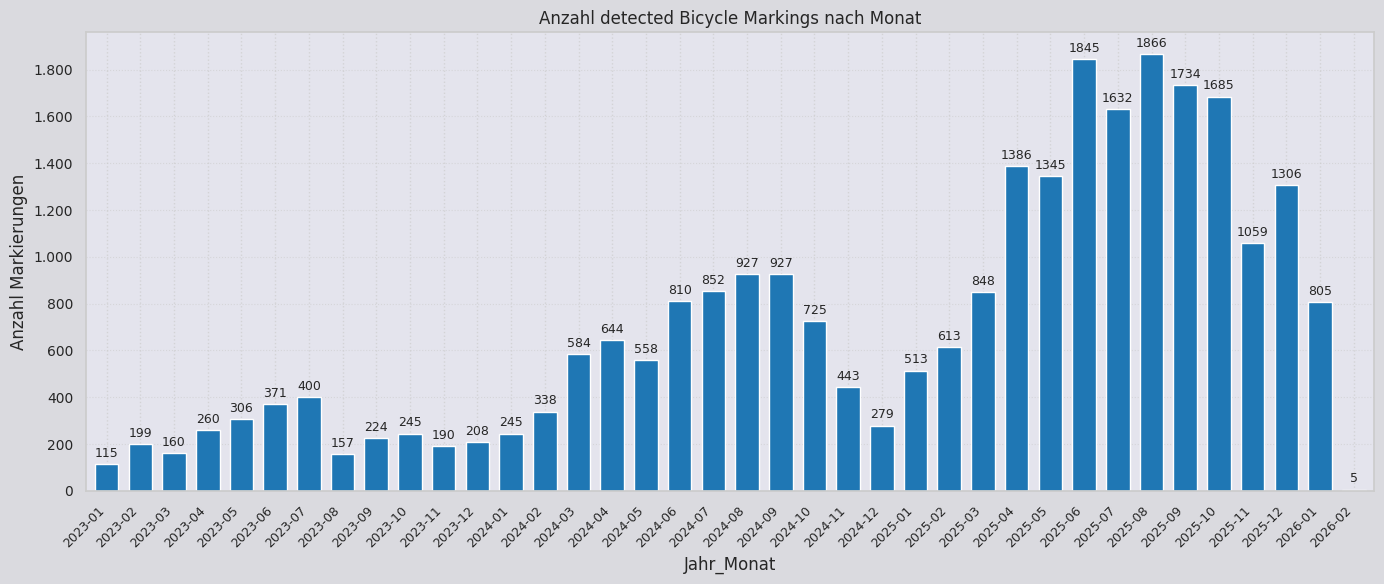

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter

df = mapillary_mf_points_cw.copy()
df["month"] = pd.to_datetime(df["last_seen_at"]).dt.to_period("M").dt.to_timestamp()

# Count by month
counts_by_month = df.groupby("month").size()

# === Plot ===
fig, ax = plt.subplots(figsize=(14, 6))
counts_by_month.plot(kind="bar", ax=ax, color="#1f77b4", width=0.7)

# Achsen & Layout
ax.set_xticklabels([d.strftime("%Y-%m") for d in counts_by_month.index], rotation=45, ha="right")
ax.tick_params(axis="x", labelsize=9)

# keine wissenschaftliche Notation
ax.ticklabel_format(style='plain', axis='y')
# Tausenderpunkt (deutsches Schema)
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, pos: f"{x:,.0f}".replace(",", ".")))

ax.yaxis.set_major_locator(mtick.MaxNLocator(integer=True))
ax.tick_params(axis="y", labelsize=10)

ax.grid(axis="y", linestyle=":", linewidth=0.8, alpha=0.6)

ax.set_xlabel("Jahr_Monat")
ax.set_ylabel("Anzahl Markierungen")
ax.set_title("Anzahl detected Bicycle Markings nach Monat")

# Totals über Balken
for i, (month, total) in enumerate(counts_by_month.items()):
    if total > 0:
        ax.text(i, total + max(counts_by_month)*0.01, str(int(total)), ha="center", va="bottom", fontsize=9)

plt.tight_layout()
plt.savefig("mk_output/markings_by_month.svg", bbox_inches="tight")
plt.show()


In [22]:
# quick check
print("ml_data_from:", ml_data_from)
print("processed_date:", processed_date)
print("bundeslaender (count):", len(bundeslaender_meta) if isinstance(bundeslaender_meta, dict) else None)

ml_data_from: 2026-02-04T01:35:14.756761+00:00
processed_date: 2026-02-04T07:14:07.957571+00:00
bundeslaender (count): 16


### create readme file

In [23]:
from datetime import datetime
import pandas as pd

# Hole das Dataset-Datum aus ml-mf_metadata.json (Fallback: heute)
if processed_date:
    try:
        last_date = pd.to_datetime(processed_date).strftime("%Y-%m-%d")
    except Exception:
        last_date = datetime.now().strftime("%Y-%m-%d")
else:
    last_date = datetime.now().strftime("%Y-%m-%d")

if ml_data_from:
    try:
        first_date = pd.to_datetime(ml_data_from).strftime("%Y-%m-%d")
    except Exception:
        first_date = "N/A"
else:
    first_date = "N/A"

# Einfache Statistiken
total_count = len(mapillary_mf_points_cw)
date_range = f"{mapillary_mf_points_cw['first_seen_at'].min()} - {mapillary_mf_points_cw['last_seen_at'].max()}"

# === README-Text ===
readme_content = f"""
# Bicycle Marking Detections Output

This folder contains the output file for detected bicycle markings from Mapillary.  
The output has been created on **{last_date}**.

## Overview

- **Total detections**: {total_count}
- **Mapillary dataset from**: {first_date}
- **Detection period**: {date_range}
- **Marking type**: Lane marking - symbol (bicycle)

## Applied Filters

- Only detections with **2+ observations** (min. 180 days apart)
- Only detections seen after **2023-01-01**
- Restricted to **Germany** boundaries

## Output Files

- `mapillary_markings_bicycle_latest.geojson.gz` - Compressed GeoJSON with all markings
- `markings_by_month.svg` - Detection frequency over time

## Statistics Plot

![Anzahl pro Monat](markings_by_month.svg)
"""

# === Datei schreiben ===
with open("mk_output/README.md", "w", encoding="utf-8") as readme_file:
    readme_file.write(readme_content)

print("✅ README.md erfolgreich erstellt!")

✅ README.md erfolgreich erstellt!
